<a href="https://colab.research.google.com/github/KattaLasya/PythonforDataScience/blob/main/greenhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Learning Algorithms Code

In [ ]:
# Multi-class plant growth classification: model zoo + reports
# -----------------------------------------------------------
# Dataset: /mnt/data/Greenhouse Plant Growth Metrics.csv
# Target:  Class (six classes: SA, SB, SC, TA, TB, TC)

import pandas as pd
import numpy as np
from pathlib import Path
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Models (fast + representative)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# ------------------
# Load + basic setup
# ------------------
DATA = "/content/Greenhouse Plant Growth Metrics.csv"
df = pd.read_csv(DATA)
df.columns = [c.strip() for c in df.columns]

assert "Class" in df.columns, "Target column 'Class' not found."
X = df.drop(columns=["Class"])
y = df["Class"].astype(str)

# Categorical vs numeric
cat_cols = [c for c in X.columns if X[c].dtype == "object"]     # e.g., Random (R1/R2/R3)
num_cols = [c for c in X.columns if c not in cat_cols]

# --------------------
# Preprocessing blocks
# --------------------
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_linear = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler(with_mean=False))]), num_cols),
    ("cat", categorical, cat_cols),
])

preprocess_tree = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", categorical, cat_cols),
])

# -------------------------
# Train/test split (Strat.)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# OPTIONAL: Speed cap for quick iteration/demo (remove to use all 30,000 rows)
MAX_TRAIN = 3000
if X_train.shape[0] > MAX_TRAIN:
    tmp = X_train.copy()
    tmp["__y__"] = y_train.values
    per_class = max(1, MAX_TRAIN // y_train.nunique())
    sub = tmp.groupby("__y__", group_keys=False)\
             .apply(lambda g: g.sample(min(len(g), per_class), random_state=42))
    y_train = sub["__y__"].astype(str)
    X_train = sub.drop(columns=["__y__"])

# ----------------
# Model zoo (fast)
# ----------------
models = {
    "LogisticRegression(saga)": Pipeline([
        ("prep", preprocess_linear),
        ("clf", LogisticRegression(solver="saga", max_iter=300, class_weight="balanced", n_jobs=-1))
    ]),
    "LinearSVC": Pipeline([
        ("prep", preprocess_linear),
        ("clf", LinearSVC(class_weight="balanced", max_iter=2000))
    ]),
    "GaussianNB": Pipeline([
        ("prep", preprocess_linear),
        ("clf", GaussianNB())
    ]),
    "LDA": Pipeline([
        ("prep", preprocess_linear),
        ("clf", LinearDiscriminantAnalysis())
    ]),
    "RandomForest(150)": Pipeline([
        ("prep", preprocess_tree),
        ("clf", RandomForestClassifier(n_estimators=150, class_weight="balanced_subsample",
                                       random_state=42, n_jobs=-1))
    ]),
    "ExtraTrees(150)": Pipeline([
        ("prep", preprocess_tree),
        ("clf", ExtraTreesClassifier(n_estimators=150, random_state=42, n_jobs=-1))
    ]),
    "GradientBoosting(100)": Pipeline([
        ("prep", preprocess_tree),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
    "MLP(64-32)": Pipeline([
        ("prep", preprocess_linear),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,32), max_iter=150, random_state=42))
    ]),
}

# ---------------
# Train + Evaluate
# ---------------
rows, reports = [], []
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")
        f1w = f1_score(y_test, y_pred, average="weighted")
        report = classification_report(y_test, y_pred, digits=4)
        rows.append({"Model": name, "Accuracy": acc, "F1_macro": f1m, "F1_weighted": f1w})
        reports.append(f"===== {name} =====\n{report}\n")
    except Exception as e:
        rows.append({"Model": name, "Accuracy": np.nan, "F1_macro": np.nan, "F1_weighted": np.nan})
        reports.append(f"===== {name} =====\nFAILED: {e}\n")

# ------------------------
# Save artifacts for paper
# ------------------------
# Create the directory if it doesn't exist
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

summary_df = pd.DataFrame(rows).sort_values(["F1_macro","F1_weighted","Accuracy"], ascending=False)
summary_df.to_csv(f"{output_dir}/model_metrics_summary_FAST.csv", index=False)

with open(f"{output_dir}/model_classification_reports_FAST.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(reports))

print("Saved:")
print(f" - {output_dir}/model_metrics_summary_FAST.csv")
print(f" - {output_dir}/model_classification_reports_FAST.txt")
print(summary_df)

/tmp/ipython-input-995508218.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), per_class), random_state=42))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Saved:
 - /mnt/data/model_metrics_summary_FAST.csv
 - /mnt/data/model_classification_reports_FAST.txt
                      Model  Accuracy  F1_macro  F1_weighted
0  LogisticRegression(saga)       1.0       1.0          1.0
1                 LinearSVC       1.0       1.0          1.0
2                GaussianNB       1.0       1.0          1.0
3                       LDA       1.0       1.0          1.0
4         RandomForest(150)       1.0       1.0          1.0
5           ExtraTrees(150)       1.0       1.0          1.0
6     GradientBoosting(100)       1.0       1.0          1.0
7                MLP(64-32)       1.0       1.0          1.0


Reinforcement Learning Algorithms Code

In [9]:
!pip install stable-baselines3[extra] gymnasium -q

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --------------------------
# Load and preprocess data
# --------------------------
data = pd.read_csv("/content/Greenhouse Plant Growth Metrics.csv")

X = data.drop(["Random", "Class"], axis=1).values
le = LabelEncoder()
y = le.fit_transform(data["Class"])

scaler = StandardScaler()
X = scaler.fit_transform(X)

# --------------------------
# Define Custom Gym Environment
# --------------------------
class GreenhouseEnv(gym.Env):
    def __init__(self, X, y):
        super(GreenhouseEnv, self).__init__()
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.n_classes = len(np.unique(y))

        self.action_space = spaces.Discrete(self.n_classes)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.n_features,), dtype=np.float32
        )
        self.current_index = 0

    def reset(self, seed=None, options=None):
        self.current_index = np.random.randint(0, self.n_samples)
        return self.X[self.current_index], {}

    def step(self, action):
        true_label = self.y[self.current_index]
        reward = 1 if action == true_label else -1
        done = True
        info = {}
        obs, _ = self.reset()
        return obs, reward, done, False, info

# --------------------------
# Train PPO Agent
# --------------------------
env = GreenhouseEnv(X, y)
model = PPO("MlpPolicy", env, verbose=0, device="auto")
print("Training reinforcement learning agent on greenhouse dataset...")
model.learn(total_timesteps=10000)
print("Training complete.")

# --------------------------
# Evaluate PPO Agent
# --------------------------
correct, total = 0, 1000
for _ in range(total):
    obs, _ = env.reset()
    action, _ = model.predict(obs, deterministic=True)
    true_label = y[env.current_index]
    if action == true_label:
        correct += 1

accuracy = correct / total
print(f"\nReinforcement Learning Agent Accuracy: {accuracy:.2%}")


Training reinforcement learning agent on greenhouse dataset...
Training complete.

Reinforcement Learning Agent Accuracy: 100.00%


Deep Learning Algorithms Code

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import pandas as pd

# --------------------------
# Load dataset
# --------------------------
data = pd.read_csv("/content/Greenhouse Plant Growth Metrics.csv")

# Drop non-numeric ID-like column
X = data.drop(["Random", "Class"], axis=1)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(data["Class"])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------
# Build Model
# --------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')  # multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# Train with early stopping
# --------------------------
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[callback],
    verbose=1
)

# --------------------------
# Evaluate
# --------------------------
y_pred = model.predict(X_test).argmax(axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8440 - loss: 0.4809 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 7.5501e-05
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 1.3530e-05
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 4.6813e-06
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 9.3980e-04 - val_accuracy: 1.0000 - val_loss: 1.8497e-06
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.1023e-04 - val_accuracy: 1.0000 - val_loss: 9.3102e-07
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 4.5724e-04 - val_accuracy: 1.0000 - val_loss: 4.1530e-07
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.00

In [25]:
# ==============================
# Ensemble Supervised Learning for Plant Growth Classification
# Dataset: Advanced IoT Agriculture Dataset
# ==============================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import sklearn

# ==============================
# Load Dataset
# ==============================
DATA_PATH = "/content/Greenhouse Plant Growth Metrics.csv"  # Update if needed
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print("Columns:", df.columns)

# Features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Column types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# ==============================
# Preprocessing Pipelines
# ==============================
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# OneHotEncoder fix for sklearn >=1.2
if sklearn.__version__ >= "1.2":
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
else:
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preproc = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], remainder="drop")

# ==============================
# Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# Ensemble Models
# ==============================
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Bagging fix for sklearn >=1.2
if sklearn.__version__ >= "1.2":
    bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
else:
    bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)

models = {
    "Bagging": bagging,
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "Voting": VotingClassifier(estimators=[
        ("lr", LogisticRegression(max_iter=2000)),
        ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
        ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42))
    ], voting="soft"),
    "Stacking": StackingClassifier(
        estimators=[
            ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
            ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ("svc", SVC(probability=True, random_state=42))
        ],
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=True
    )
}

# ==============================
# Train, Evaluate & Save Results
# ==============================
summary = []
reports = []

for name, model in models.items():
    pipe = Pipeline([("preproc", preproc), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    summary.append([name, acc, f1_macro, f1_weighted])
    reports.append(f"\n==== {name} ====\n" + classification_report(y_test, y_pred))

    print(f"{name} -> Accuracy: {acc:.4f}, Macro-F1: {f1_macro:.4f}")

# Save summary
summary_df = pd.DataFrame(summary, columns=["Model", "Accuracy", "Macro_F1", "Weighted_F1"])
summary_df.to_csv("ensemble_model_summary.csv", index=False)

with open("ensemble_classification_reports.txt", "w") as f:
    for r in reports:
        f.write(r)

print("\nResults saved: ensemble_model_summary.csv & ensemble_classification_reports.txt")


Dataset shape: (30000, 14)
Columns: Index(['Random', 'ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD', 'ADWR',
       'PDMVG', 'ARL', 'AWWR', 'ADWV', 'PDMRG', 'Class'],
      dtype='object')
Numeric cols: ['ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD', 'ADWR', 'PDMVG', 'ARL', 'AWWR', 'ADWV', 'PDMRG']
Categorical cols: ['Random']
Bagging -> Accuracy: 1.0000, Macro-F1: 1.0000
RandomForest -> Accuracy: 1.0000, Macro-F1: 1.0000
ExtraTrees -> Accuracy: 1.0000, Macro-F1: 1.0000
GradientBoosting -> Accuracy: 1.0000, Macro-F1: 1.0000
Voting -> Accuracy: 1.0000, Macro-F1: 1.0000


KeyboardInterrupt: 

Finalised Algorithm: Gradient Boosting Code

Dataset Preview:
   Random       ACHP        PHR     AWWGV         ALAP      ANPL        ARD  \
0     R1  34.533468  54.566983  1.147449  1284.229549  4.999713  16.274918   
1     R1  34.489028  54.567692  1.149530  1284.247744  5.024259  16.269452   
2     R2  33.100405  67.067344  1.104647  1009.208996  5.007652  15.980760   
3     R1  34.498319  54.559049  1.137759  1284.227623  4.991501  16.276710   
4     R3  36.297008  45.588894  1.363205   981.470310  4.003682  16.979894   

       ADWR      PDMVG        ARL      AWWR      ADWV      PDMRG Class  
0  1.706810  18.399982  19.739037  2.949240  0.209251  57.633906    SA  
1  1.700930  18.398289  19.758836  2.943137  0.216154  57.633697    SA  
2  1.185391  19.398789  20.840822  2.861635  0.200113  41.289875    SA  
3  1.716396  18.413613  19.736098  2.946784  0.223092  57.645661    SA  
4  0.777428  31.423772  17.331894  2.766242  0.424172  27.898619    SA  

Columns in the dataset:
 Index(['Random', 'ACHP', 'PHR', 'AWWGV', 'ALAP', 

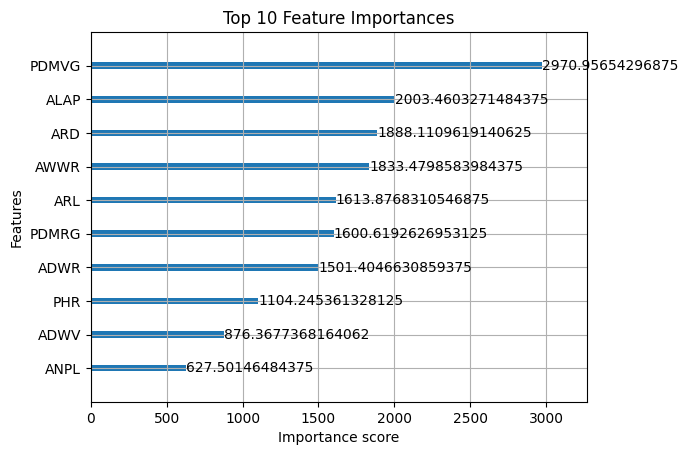

In [24]:
# ===============================
# Optimized XGBoost for Multi-class Greenhouse Crop Classification
# Advanced IoT Agriculture Dataset
# ===============================

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load Dataset
# -------------------------------
data = pd.read_csv('/content/Greenhouse Plant Growth Metrics.csv')  # Replace with your dataset path

# Preview dataset
print("Dataset Preview:\n", data.head())
print("\nColumns in the dataset:\n", data.columns)

# -------------------------------
# 2. Clean Column Names
# -------------------------------
data.columns = data.columns.str.strip()

# Drop non-predictive columns
if 'Random' in data.columns:
    data = data.drop('Random', axis=1)

# -------------------------------
# 3. Separate Features and Target
# -------------------------------
target_column = 'Class'
X = data.drop(target_column, axis=1)
y = data[target_column]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# -------------------------------
# 4. Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -------------------------------
# 5. Define XGBoost Classifier
# -------------------------------
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# -------------------------------
# 6. Hyperparameter Tuning
# -------------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# -------------------------------
# 7. Model Evaluation
# -------------------------------
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# -------------------------------
# 8. Feature Importance
# -------------------------------
# Use 'gain' for more informative feature importance
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()
